In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

### Carga data

In [2]:
infile = open('cleandata_pickle.pickle','rb')
data_clean = pickle.load(infile)
infile.close()

Agregar variables temporales

In [3]:
data_clean['dow_creacion'] = data_clean['dttm_creacion'].dt.dayofweek
data_clean['hora_creacion'] = data_clean['dttm_creacion'].dt.hour
data_clean['mes_creacion'] = data_clean['dttm_creacion'].dt.month
data_clean['año_creacion'] = data_clean['dttm_creacion'].dt.year
data_clean['fecha_creacion'] = data_clean['dttm_creacion'].dt.floor('D')
data_clean['dow_cierre'] = data_clean['dttm_cierre'].dt.dayofweek
data_clean['hora_cierre'] = data_clean['dttm_cierre'].dt.hour
data_clean['mes_cierre'] = data_clean['dttm_cierre'].dt.month
data_clean['año_cierre'] = data_clean['dttm_cierre'].dt.year
data_clean['fecha_cierre'] = data_clean['dttm_cierre'].dt.floor('D')
data_clean.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,dow_creacion,hora_creacion,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.33929,-99.25598,URGENCIAS MEDICAS,LLAMADA DEL 066,alvaro obregon,2013-12-31 23:21:38,...,1,23,12,2013,2013-12-31,2,1,1,2014,2014-01-01
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.37831,-99.20090,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2013-12-31 18:21:47,...,1,18,12,2013,2013-12-31,3,0,1,2014,2014-01-02
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.36336,-99.19104,URGENCIAS MEDICAS,LLAMADA DEL 066,alvaro obregon,2014-01-01 21:45:43,...,2,21,1,2014,2014-01-01,2,23,1,2014,2014-01-01
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.36348,-99.19145,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2014-01-01 21:46:46,...,2,21,1,2014,2014-01-01,2,21,1,2014,2014-01-01
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.38161,-99.20009,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2014-01-01 06:50:48,...,2,6,1,2014,2014-01-01,2,8,1,2014,2014-01-01


### Agrega columna label. Identifica las llamadas falsas de las verdaderas

Es importante hacer una distinción entre "registros recibidos" e "incidentes reales".

Los registros recibidos contemplan todos los códigos de cierre, mientras que para conservar los incidentes es necesario quitar las solicitudes de informacion, y los incidentes repetidos, es decir, códigos de cierre *D* e *I*.

In [4]:
data_incidentes = data_clean.query('codigo_cierre not in ["D", "I"]') 
data_incidentes

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,dow_creacion,hora_creacion,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre
1164271,C4/131231/03508,A,alvaro obregon,lesionado_atropellado,19.339290,-99.255980,URGENCIAS MEDICAS,LLAMADA DEL 066,alvaro obregon,2013-12-31 23:21:38,...,1,23,12,2013,2013-12-31,2,1,1,2014,2014-01-01
1164423,C4/131231/02371,N,alvaro obregon,accidente_choque_sin_lesionados,19.378310,-99.200900,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2013-12-31 18:21:47,...,1,18,12,2013,2013-12-31,3,0,1,2014,2014-01-02
372612,C4/140101/04189,A,alvaro obregon,accidente_choque_con_lesionados,19.363360,-99.191040,URGENCIAS MEDICAS,LLAMADA DEL 066,alvaro obregon,2014-01-01 21:45:43,...,2,21,1,2014,2014-01-01,2,23,1,2014,2014-01-01
372622,C4/140101/04201,A,alvaro obregon,accidente_choque_sin_lesionados,19.363480,-99.191450,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2014-01-01 21:46:46,...,2,21,1,2014,2014-01-01,2,21,1,2014,2014-01-01
372628,C4/140101/01293,A,alvaro obregon,accidente_choque_sin_lesionados,19.381610,-99.200090,EMERGENCIA,LLAMADA DEL 066,alvaro obregon,2014-01-01 06:50:48,...,2,6,1,2014,2014-01-01,2,8,1,2014,2014-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380278,C5/201031/08038,N,xochimilco,accidente_choque_sin_lesionados,19.286861,-99.102211,EMERGENCIA,LLAMADA DEL 911,xochimilco,2020-10-31 21:27:39,...,5,21,10,2020,2020-10-31,5,21,10,2020,2020-10-31
1380309,C5/201031/08206,A,xochimilco,accidente_choque_con_lesionados,19.234770,-99.120500,URGENCIAS MEDICAS,LLAMADA DEL 911,xochimilco,2020-10-31 21:39:56,...,5,21,10,2020,2020-10-31,5,22,10,2020,2020-10-31
1380319,C5/201031/02258,A,xochimilco,accidente_choque_sin_lesionados,19.283730,-99.129490,EMERGENCIA,LLAMADA DEL 911,xochimilco,2020-10-31 06:51:39,...,5,6,10,2020,2020-10-31,5,9,10,2020,2020-10-31
1382445,C5/201031/07490,N,xochimilco,accidente_choque_con_lesionados,19.210047,-99.132963,URGENCIAS MEDICAS,LLAMADA DEL 911,xochimilco,2020-10-31 20:41:36,...,5,20,10,2020,2020-10-31,5,22,10,2020,2020-10-31


In [5]:
data_incidentes['label'] = np.where((data_incidentes['codigo_cierre'] == 'N') | (data_incidentes['codigo_cierre'] == 'F') ,1,0 )
data_incidentes.loc[data_incidentes.codigo_cierre == 'F']

/home/mario/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,dttm_creacion,...,hora_creacion,mes_creacion,año_creacion,fecha_creacion,dow_cierre,hora_cierre,mes_cierre,año_cierre,fecha_cierre,label
1164691,C4/140105/00980,F,alvaro obregon,accidente_choque_con_lesionados,19.353980,-99.243360,FALSA ALARMA,LLAMADA DEL 066,alvaro obregon,2014-01-05 05:08:37,...,5,1,2014,2014-01-05,6,5,1,2014,2014-01-05,1
499866,C4/140203/00549,F,alvaro obregon,accidente_choque_sin_lesionados,19.331070,-99.210570,FALSA ALARMA,LLAMADA DEL 066,alvaro obregon,2014-02-03 02:36:57,...,2,2,2014,2014-02-03,0,2,2,2014,2014-02-03,1
502034,C4/140211/01207,F,alvaro obregon,accidente_choque_sin_lesionados,19.342470,-99.204530,FALSA ALARMA,RADIO,alvaro obregon,2014-02-11 12:39:33,...,12,2,2014,2014-02-11,1,12,2,2014,2014-02-11,1
503014,C4/140214/04023,F,alvaro obregon,accidente_choque_sin_lesionados,19.305470,-99.205900,FALSA ALARMA,LLAMADA DEL 066,alvaro obregon,2014-02-14 21:55:55,...,21,2,2014,2014-02-14,4,22,2,2014,2014-02-14,1
1174656,C4/140220/00863,F,alvaro obregon,lesionado_atropellado,19.340520,-99.203100,FALSA ALARMA,LLAMADA DEL 066,alvaro obregon,2014-02-20 10:04:41,...,10,2,2014,2014-02-20,3,10,2,2014,2014-02-20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343088,C5/200915/04154,F,xochimilco,accidente_choque_sin_lesionados,19.257870,-99.079960,FALSA ALARMA,LLAMADA DEL 911,xochimilco,2020-09-15 15:45:53,...,15,9,2020,2020-09-15,2,4,9,2020,2020-09-16,1
1343157,C5/200915/09422,F,xochimilco,accidente_choque_sin_lesionados,19.294354,-99.102441,FALSA ALARMA,LLAMADA DEL 911,xochimilco,2020-09-15 23:21:36,...,23,9,2020,2020-09-15,2,1,9,2020,2020-09-16,1
1345742,C5/200925/06785,F,xochimilco,accidente_choque_sin_lesionados,19.268240,-99.125560,FALSA ALARMA,LLAMADA DEL 911,xochimilco,2020-09-25 21:33:15,...,21,9,2020,2020-09-25,5,0,9,2020,2020-09-26,1
1373474,C5/201003/03298,F,xochimilco,accidente_choque_sin_lesionados,19.248450,-99.125990,FALSA ALARMA,LLAMADA DEL 911,xochimilco,2020-10-03 12:15:54,...,12,10,2020,2020-10-03,5,12,10,2020,2020-10-03,1


### Gráficas

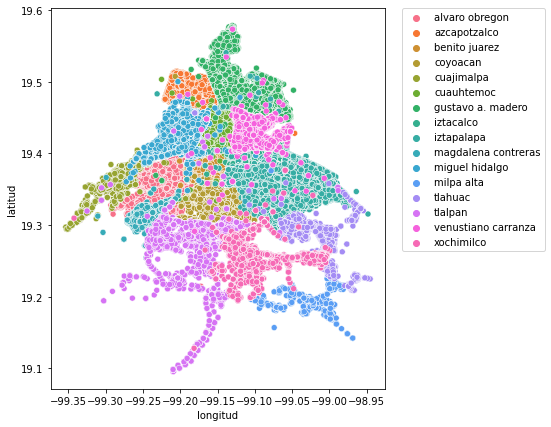

In [6]:
f = plt.subplots(figsize = (6,7))

sns.scatterplot(data = data_clean[data_clean['año_cierre'] == 2019] , y = "latitud", x = "longitud", hue = "delegacion_cierre")

ax = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Llamadas por día de la semana X hora de creación

In [7]:
dow_x_hora_creacion = data_clean[['dow_creacion', 'hora_creacion']].groupby(['dow_creacion', 'hora_creacion']).\
size().reset_index(name='n').pivot("hora_creacion", "dow_creacion","n")

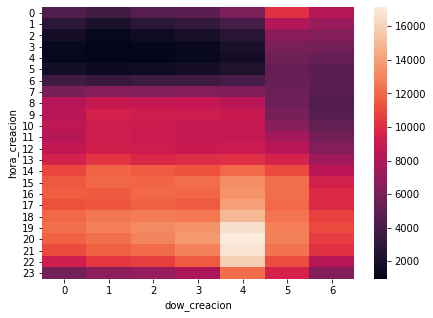

In [8]:
f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(dow_x_hora_creacion)

Cuando más llamadas hay es los viernes entre 18 y 22 hrs. Cuando menos llamadas hay es de lunes a viernes de 12am a 6am

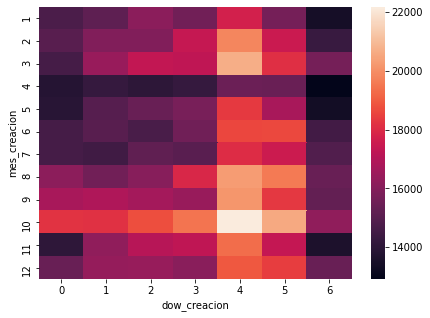

In [9]:
dow_x_mes_creacion = data_clean[['dow_creacion', 'mes_creacion']].groupby(['dow_creacion', 'mes_creacion']).\
size().reset_index(name='n').pivot("mes_creacion", "dow_creacion","n")

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(dow_x_mes_creacion)

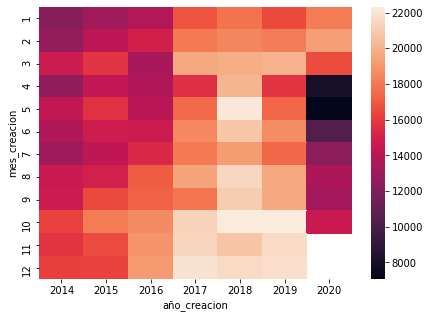

In [10]:
año_x_mes_creacion = data_clean[['año_creacion', 'mes_creacion']].groupby(['año_creacion', 'mes_creacion']).\
size().reset_index(name='n').query('año_creacion != 2013').pivot("mes_creacion", "año_creacion","n")

f = plt.subplots(figsize = (7,5))
ax = sns.heatmap(año_x_mes_creacion)

### Llamadas por delegación

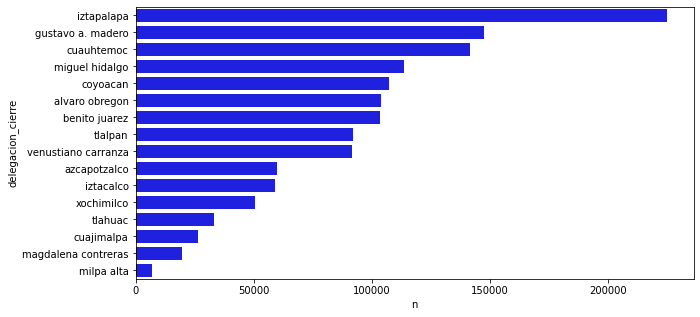

In [11]:
llamadas_x_deleg = data_clean.groupby(['delegacion_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)

f = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = llamadas_x_deleg, x = 'n', y = 'delegacion_cierre', color= 'b')

### Llamadas por año

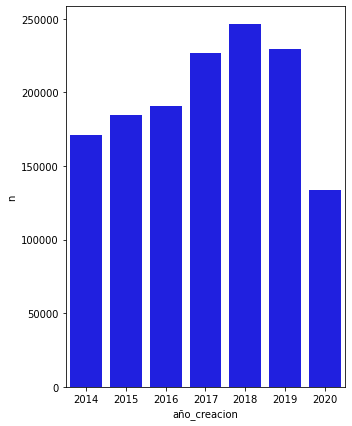

In [12]:
llamadas_x_año = data_clean.query('año_creacion != 2013').groupby(['año_creacion']).size().reset_index(name = "n").sort_values("n", ascending = False)
llamadas_x_año['año_creacion'] = llamadas_x_año['año_creacion'].astype("object")

f = plt.subplots(figsize = (5,7))
ax = sns.barplot(data = llamadas_x_año, y = 'n', x = 'año_creacion', color= 'b')

### Serie de tiempo llamadas

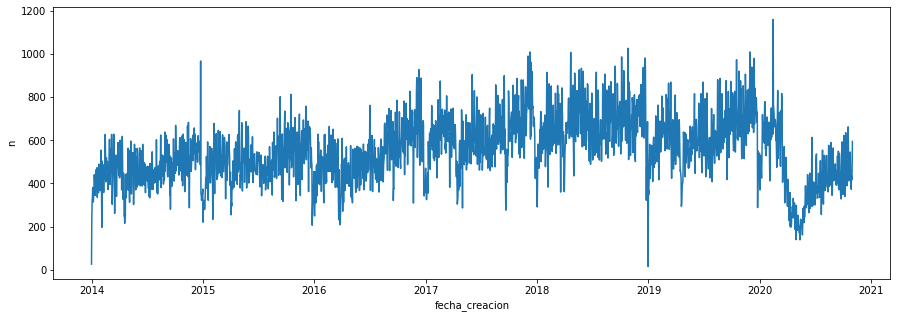

In [13]:
llamadas_diarias = data_clean.groupby(['fecha_creacion']).size().reset_index(name = "n")
f = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data = llamadas_diarias, x = 'fecha_creacion', y = 'n')

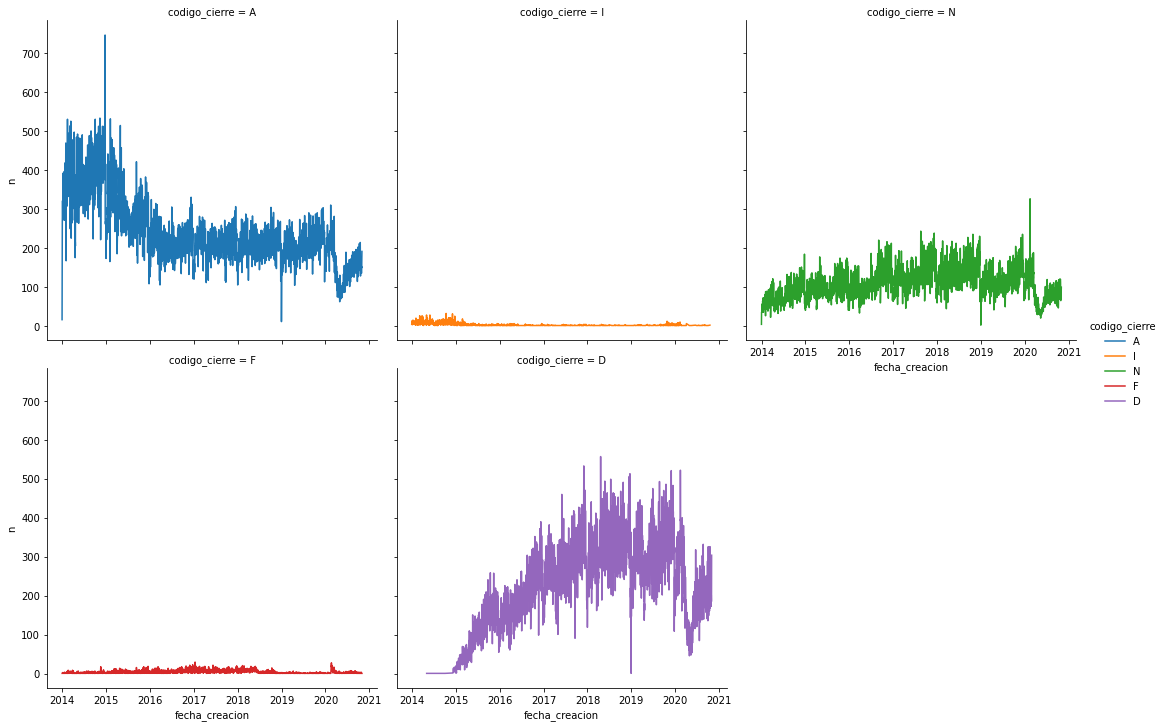

In [14]:
llamadas_diarias_codigo = data_clean.groupby(['fecha_creacion', 'codigo_cierre']).size().reset_index(name = "n")
llamadas_diarias_codigo

#f = plt.subplots(figsize = (15,5))
ax = sns.relplot(data = llamadas_diarias_codigo, x = 'fecha_creacion', y = 'n', hue = 'codigo_cierre', col = 'codigo_cierre', kind = 'line', col_wrap = 3)

In [15]:
llamadas_diarias_label = data_clean.groupby(['fecha_creacion', 'label']).size().reset_index(name = "n")

#f = plt.subplots(figsize = (15,5))
ax = sns.relplot(data = llamadas_diarias_label, x = 'fecha_creacion', y = 'n', col = 'label', kind = 'line', col_wrap = 1)

KeyError: 'label'

In [ ]:
llamadas_x_incidente = data_clean.groupby(['incidente_c4']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (12,6))
ax = sns.barplot(data = llamadas_x_incidente, x = 'n', y = 'incidente_c4', color= 'b')

In [ ]:
llamadas_x_codigo_cierre = data_clean.groupby(['codigo_cierre']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_codigo_cierre, x = 'n', y = 'codigo_cierre', color= 'g')

In [ ]:
llamadas_x_clas = data_clean.groupby(['clas_con_f_alarma']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_clas, x = 'n', y = 'clas_con_f_alarma', color= 'b')

In [ ]:
llamadas_x_tipo_entrada = data_clean.groupby(['tipo_entrada']).size().reset_index(name = "n").sort_values("n", ascending = False)
f = plt.subplots(figsize = (8,6))
ax = sns.barplot(data = llamadas_x_tipo_entrada, x = 'n', y = 'tipo_entrada', color= 'orange')

In [ ]:
data_clean.groupby(['clas_con_f_alarma','codigo_cierre']).size().reset_index(name = "n").\
sort_values("n", ascending = False).pivot('clas_con_f_alarma', 'codigo_cierre','n')